# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [11]:
import os

# Drag and Drop your kaggle.json in the File option from the sidebar
# Then run this cell

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!chmod 600 /content/kaggle.json
!kaggle datasets download -d moltean/fruits
!unzip -q fruits.zip -d /content/fruits_dataset

training_path = ""
for root, dirs, files in os.walk("/content/fruits_dataset"):
    if "Training" in dirs:
        training_path = os.path.join(root, "Training")
        break

print(training_path)

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 99% 4.85G/4.90G [00:40<00:01, 37.4MB/s]
100% 4.90G/4.90G [00:41<00:00, 128MB/s] 
/content/fruits_dataset/fruits-360_3-body-problem/fruits-360-3-body-problem/Training


In [12]:
import cv2
import numpy as np
import torch
import glob
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [56]:
class Fruits(Dataset):

    def __init__(self, root_dir):
        # Find all jpg files
        self.files = glob.glob(os.path.join(root_dir, "*", "*.jpg"))

        # Label everything
        self.classes = sorted(os.listdir(root_dir))
        self.cls_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]

        # Load image
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            return self.__getitem__((idx + 1) % len(self))

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # Get label
        label_name = os.path.basename(os.path.dirname(path))
        label = self.cls_to_idx.get(label_name, 0)

        # Get Canny Edges
        canny_dict = get_canny(img_rgb)
        contour_img = np.zeros_like(img_gray)
        cv2.drawContours(contour_img, canny_dict["contours"], -1, (255), 1)

        # Shape Features
        lbp = get_lbp(img_gray)
        shape_feats = get_features(img_rgb, canny_dict)

        # Color features
        means, stds = cv2.meanStdDev(img_rgb)
        color_feats = np.concatenate([means, stds]).flatten()

        return {
            "image": torch.tensor(img_rgb).permute(2, 0, 1).float() / 255.0,
            "canny": torch.tensor(contour_img).unsqueeze(0).float() / 255.0,
            "lbp":   torch.tensor(lbp).unsqueeze(0).float() / 255.0,
            "shape_features": torch.tensor(shape_feats).float(),
            "color_features": torch.tensor(color_feats).float(),
            "label": torch.tensor(label).long()
        }

In [51]:
def get_lbp(img_gray) :

    # Shape
    rows, cols = img_gray.shape

    # padding
    img_padded = cv2.copyMakeBorder(img_gray, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
    lbp_img = np.zeros_like(img_gray, dtype=np.uint8)

    # LBP
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]
    weights = [1, 2, 4, 8, 16, 32, 64, 128]

    center = img_padded[1:-1, 1:-1]

    for (dy, dx), power in zip(neighbors, weights):
        # shift view to neighbor
        view = img_padded[1+dy : rows+1+dy, 1+dx : cols+1+dx]

        # if neighbor >= center add the power
        lbp_img += (view >= center).astype(np.uint8) * power

    return lbp_img

In [52]:
def get_canny(rgb_img: np.ndarray,white_threshold: int = 240,min_contour_area: int = 100) -> dict:

    if rgb_img.ndim != 3 or rgb_img.shape[2] != 3:
        raise ValueError("Input must be an RGB image with shape (H, W, 3)")

    # Convert to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

    # Binary mask
    _, mask = cv2.threshold(
        gray,
        white_threshold,
        255,
        cv2.THRESH_BINARY_INV
    )

    # Cleaning the mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # Filtering tiny contours
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_contour_area]

    return {
        "mask": mask,
        "contours": contours,
        "hierarchy": hierarchy
    }



In [53]:
def get_color_feats(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    H = hsv[:, :, 0].astype(np.float32)
    S = hsv[:, :, 1].astype(np.float32)
    V = hsv[:, :, 2].astype(np.float32)

    # raw features
    feats = np.array([np.mean(H), np.std(H), np.mean(S),np.std(S),np.mean(V), np.std(V)], dtype=np.float32)

    # normalization
    normalize = np.array([179, 179, 255, 255, 255, 255], dtype=np.float32)
    feats = feats / normalize

    return feats



The Six features we are looking for: Aspect Ratio, Extent, Solidity, Circularity, Eqv. Diameter and Perimeter.

In [54]:
def get_features(img_rgb, canny_dict):
    mask = canny_dict["mask"]
    contours = canny_dict["contours"]

    if len(contours) == 0:
        return np.zeros(6, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea)

    # Basic geometry
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    # Aspect ratio
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h != 0 else 0

    rect_area = w * h
    extent = area / rect_area   if rect_area > 0 else 0

    # Convex hull
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)

    # Solidity
    solidity = area/hull_area  if hull_area > 0 else 0

    # Circularity
    circularity = (4*np.pi*area)/(perimeter**2) if perimeter > 0 else 0

    # Equivalent diameter
    equiv_diameter = np.sqrt(4*area/np.pi)  if area>0 else 0

    return np.array([
        aspect_ratio,
        extent,
        solidity,
        circularity,
        equiv_diameter,
        perimeter
    ], dtype=np.float32)



Image 1 (Cherry 1):
Color: [ 99.7   81.42  81.51  97.86 107.79 107.65]
Shape: [  1.02   0.75   0.97   0.73  97.05 357.04]

Image 2 (Cherry Rainier 3):
Color: [231.02 147.28 150.83  31.6   79.14  78.58]
Shape: [  1.2    0.82   0.99   0.87  93.24 313.38]

Image 3 (Cherry Rainier 2):
Color: [202.28 190.39 159.46  35.02  44.11  58.27]
Shape: [  1.04   0.8    0.98   0.85  99.06 336.69]

Image 4 (Cherry Rainier 2):
Color: [207.3  185.45 161.47  34.99  50.57  62.83]
Shape: [  0.94   0.78   0.99   0.88  96.62 323.66]

Image 5 (Cherry 2):
Color: [173.47 104.05 111.07  51.91  90.63  87.32]
Shape: [  1.05   0.8    0.98   0.87  98.15 331.52]


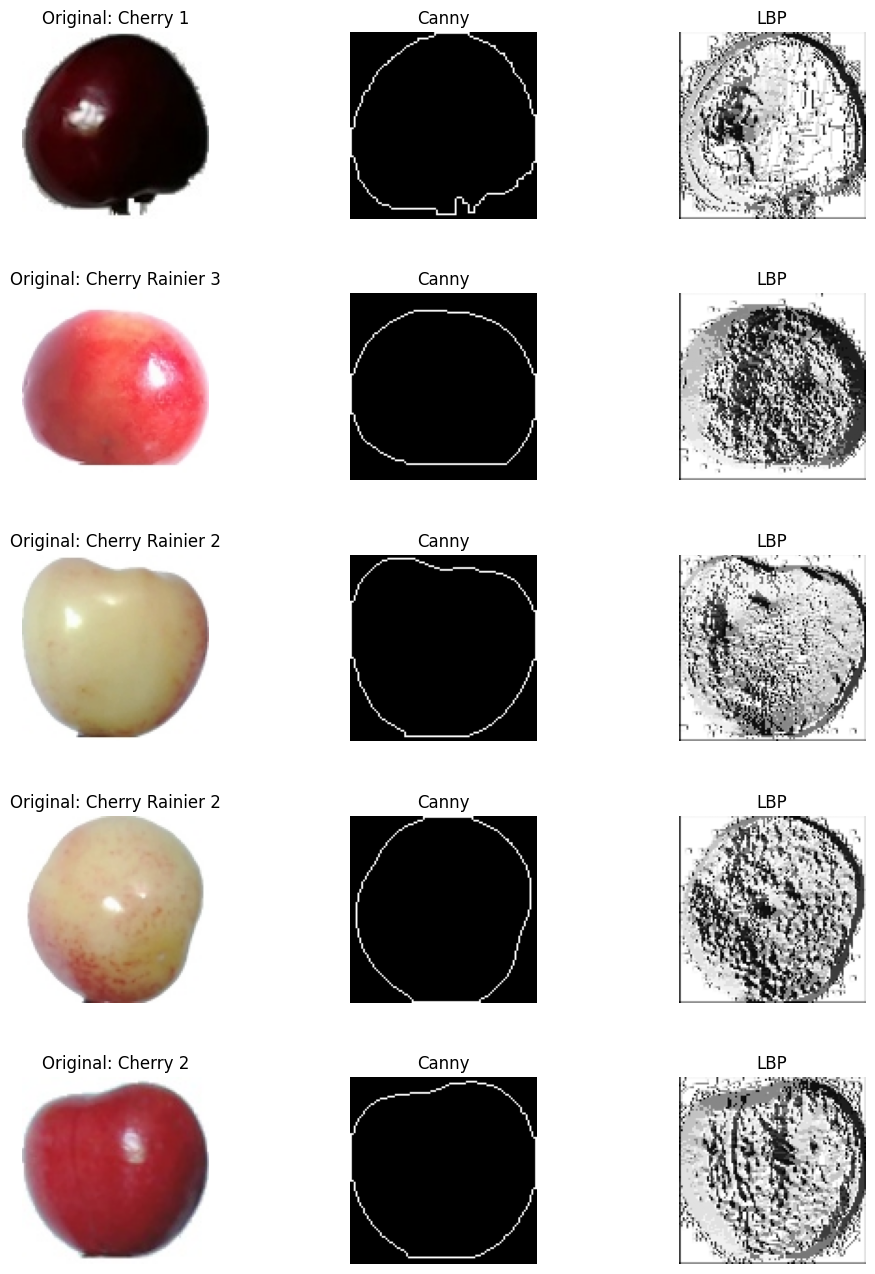

In [57]:
import os

all_files = glob.glob("/content/fruits_dataset/**/*.jpg", recursive=True)
root_dir = os.path.dirname(os.path.dirname(all_files[0]))

dataset = Fruits(root_dir)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
batch = next(iter(dataloader))

images = batch['image']
cannys = batch['canny']
lbps = batch['lbp']
shape_f = batch['shape_features']
color_f = batch['color_features']
labels = batch['label']
class_names = dataset.classes

fig, axes = plt.subplots(5, 3, figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)

for i in range(5):
    img_display = images[i].permute(1, 2, 0).numpy()
    axes[i, 0].imshow(img_display)

    lbl_idx = labels[i].item()
    title = class_names[lbl_idx] if lbl_idx < len(class_names) else str(lbl_idx)

    axes[i, 0].set_title(f"Original: {title}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cannys[i].squeeze().numpy(), cmap='gray')
    axes[i, 1].set_title("Canny")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(lbps[i].squeeze().numpy(), cmap='gray')
    axes[i, 2].set_title("LBP")
    axes[i, 2].axis('off')

    print(f"\nImage {i+1} ({title}):")
    print(f"Color: {color_f[i].numpy().round(2)}")
    print(f"Shape: {shape_f[i].numpy().round(2)}")

plt.show()